In [1]:
import os

import torch
from tqdm import tqdm
from ffcv.writer import DatasetWriter
from ffcv.fields import BytesField, IntField, RGBImageField

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset
from data_utils import texture_shape_transformations as ts
from utils.metrics import topk_acc, real_acc, AverageMeter

/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
dataset         = 'cifar10'         # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture    = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes     = CLASS_DICT[dataset]
data_path       = '/scratch/ffcv'
eval_batch_size = 1024
checkpoint      = 'in21k_imagenet'   # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
device          = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# texture shape specific parameter
dataset_type    = 'edged' # occluded, shuffled, grayscale, edged, stylized

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint= checkpoint)
#model.cuda()

In [15]:
# Get the test loader
loader = ts.get_Shapeloader(
        dataset   = dataset,
        bs        = eval_batch_size,
        mode      = "test",
        augment   = "False",
        dev       = device,
        mixup     = 0.0,
        data_path = data_path,
        data_resolution = data_resolution,
        crop_resolution = crop_resolution,
        dataset_type    = dataset_type
        )

Loading /scratch/ffcv/cifar10/val_32.beton


torch.Size([1024, 3, 64, 64]) torch.Size([1024])
(3, 64, 64)


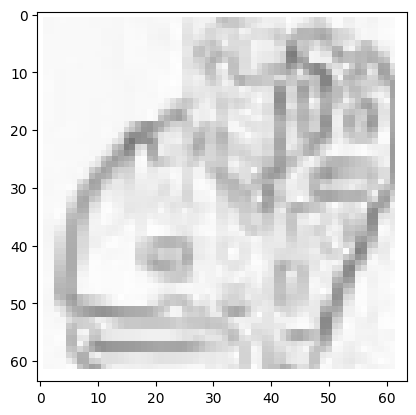

In [16]:
# image viewing
import matplotlib.pyplot as plt

with torch.no_grad():
    dataiter    = iter(loader)
    ims, labels = next(dataiter)
    img_to_show = ims[225]
    print(ims.shape, labels.shape)
    
    if not isinstance(img_to_show, np.ndarray):
        img_to_show = img_to_show.numpy()
    
    print(img_to_show.shape)
    # for shuffled images need to add .astype(np.uint8)
    plt.imshow(img_to_show.T)

In [ ]:
# Define a test function that evaluates test accuracy
# run this with different texture shape transformations 
# and keep the acc for each category.
@torch.no_grad()
def test(model, loader):
    model.eval()
    total_acc, total_top5 = AverageMeter(), AverageMeter()

    for ims, targs in tqdm(loader, desc="Evaluation"):
        ims = torch.reshape(ims, (ims.shape[0], -1))
        preds = model(ims)

        if dataset != 'imagenet_real':
            acc, top5 = topk_acc(preds, targs, k=5, avg=True)
        else:
            acc = real_acc(preds, targs, k=5, avg=True)
            top5 = 0
            
        total_acc.update(acc, ims.shape[0])
        total_top5.update(top5, ims.shape[0])


    return (
        total_acc.get_avg(percentage=True),
        total_top5.get_avg(percentage=True),
    )

In [ ]:
test_acc, test_top5 = test(model, loader)

# Print all the stats
print("Test Accuracy        ", "{:.4f}".format(test_acc))
print("Top 5 Test Accuracy          ", "{:.4f}".format(test_top5))